# TP2: Implémentation D'une Régression logistique avec régularisation Ridge (Python)

## 1. Préparation des données

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# • Charger les ensembles de données : train.csv, val.csv, test.csv.
train_path = "/content/train.csv"
val_path = "/content/val.csv"
test_path = "/content/test.csv"

# • Séparer les variables explicatives (X) et la variable cible (y) (valeurs 0 et 1 – Malade ou non).
def charger_donnees(path):
    df = pd.read_csv(path)
    X = df.iloc[:, :-1].values  #Toutes les colonnes sauf la dernière (variables explicatives)
    y = df.iloc[:, -1].values   # Dernière colonne = cible
    # Ajouter une colonne de 1 pour le biais x0
    X = np.c_[np.ones(X.shape[0]), X]  # X devient (m × 8)
    return X, y

X_train_raw, y_train = charger_donnees(train_path)
X_val_raw, y_val = charger_donnees(val_path)
X_test_raw, y_test = charger_donnees(test_path)
#affiche les dimensions des données d'entraînement (nombre de lignes et de colonnes).
print(X_train_raw.shape, y_train.shape)

# • Normaliser les variables explicatives.

def normaliser_donnees(X_train, X_val, X_test):
    scaler = StandardScaler()
    # fit_transform calcule la moyenne et l'écart type sur les données d'entraînement (fit) et les utilise pour normaliser (transform).
    X_train[:, 1:] = scaler.fit_transform(X_train[:, 1:])
    X_val[:, 1:] = scaler.transform(X_val[:, 1:])
    X_test[:, 1:] = scaler.transform(X_test[:, 1:])
    return X_train, X_val, X_test

X_train, X_val, X_test = normaliser_donnees(X_train_raw, X_val_raw, X_test_raw)


ModuleNotFoundError: No module named 'sklearn'

## 2. Implémentation des fonctions nécessaires

### 2.1 Fonction Sigmoide

### tache:
Créer une fonction Python pour calculer l'hypothèse $h_\theta(x) = 1/(1 + e^-\theta^T x$). Cette fonction prendra en entrée la matrice des caractéristiques $x$ et le vecteur de paramètres $\theta$

In [ ]:
import numpy as np

def sigmoide(X, theta):
  """
 Calcule les prédictions du modele h_theta(x) = X . theta

    Args:
        X: Matrice des caractéristiques (m exemples × n variables)
        theta: Vecteur des paramètres (n × 1)

    Returns:
        sigmoide(h_theta(x)
  """

  return 1 / (1 + np.exp(-np.dot(X, theta)))

## 2.2 Fonction De Cout Ridge

### Tache:
Créer une fonction Python pour calculer la fonction de coût $J(\theta_i)$. Cette fonction mesurera la différence entre les valeurs prédites (par la fonction sigmoide) et les valeurs cibles réelles.


In [ ]:
import numpy as np

def fonction_de_cout_ridge(X, y, theta, lambda_reg):
  """
  Calcule le coût J(theta) = (1/2m) * somme des erreurs au carré.

  Args:
    X:          Matrice des caractéristiques
    theta:      Vecteur des paramètres
    y:          Vecteur des valeurs cibles (réelles)
    lambda_reg: Coefficient de régularisation (lambda)

  Returns:
    Valeur de la fonction de coût J(theta)
  """
  m = len(y)
  predictions = sigmoide(X, theta)
  theta_reg = np.sum(theta[1:]**2)
  cost_y1 = np.log(predictions)
  cost_y0 = np.log(1 - predictions)
  cost = (-1/m) * np.sum(y * cost_y1 + (1 - y) * cost_y0 + (lambda_reg/(2*m)) * theta_reg)

  return cost

## 2.3 Descente De Gradient Ridge

### Subtask:
Creer une fonction python pour implementer une descente de gradient.

In [ ]:
import numpy as np

def descente_gradient_ridge(X, y, theta, alpha, num_iterations, lambda_reg):
  """
Applique la descente de gradient pour optimiser les paramètres avec régularisation Ridge.

  Args:
   X: Matrice des caractéristiques.
   y: Vecteur des cibles.
   theta: Vecteur initial des paramètres.
   alpha: Taux d’apprentissage.
   num_iterations: Nombre d’itérations.
   lambda_reg: Coefficient de régularisation (lambda).

  Returns:
    un tuple contenant les paramètres optimisés et une liste des coûts à chaque itération.
  """
  m = len(y)
  cost_history = []

  for i in range(num_iterations):
    predictions = sigmoide(X, theta)
    errors = predictions - y
    # Calcul du gradient avec le terme de régularisation Ridge
    gradient = (np.dot(X.T, errors) + lambda_reg * theta) / m
    theta = theta - alpha * gradient
    cost = fonction_de_cout_ridge(X, y, theta, lambda_reg)
    cost_history.append(cost)

  return theta, cost_history

## 2.3  Prediction (Sigmoïde>= 0.5 pour la classe positive):  
Cette fonction utilisera la sortie de la fonction sigmoïde et renverra 1 si la probabilité est supérieure ou égale à 0.5, et 0 sinon.

In [ ]:
def prediction(X, theta):
  """
  Effectue des prédictions binaires (0 ou 1) basées sur la sortie de la fonction sigmoïde.

  Args:
    X: Matrice des caractéristiques.
    theta: Vecteur des paramètres optimisés.

  Returns:
    Un tableau numpy de prédictions binaires (0 ou 1).
  """
  probabilities = sigmoide(X, theta)
  return (probabilities >= 0.5).astype(int)

## 3. Entraînement et recherche des hyperparamètres

In [ ]:
import numpy as np

# Nombre d’itérations pour chaque entraînement
num_iterations = 150

# Grille d'hyperparamètres à tester
learning_rates = np.arange(0.01, 1.0, 0.1) # Taux d’apprentissage (α) : de 0.01 à 1.0 avec un pas de 0.1.
lambda_regs = np.arange(0.1, 10.0, 1.0) # Coefficient de régularisation (λ) : de 0.1 à 10.0 avec un pas de 1.0.

best_accuracy = 0
best_alpha = None
best_lambda_reg = None
best_theta = None
cost_history_best = None

# Dictionnaires pour stocker les précisions pour chaque combinaison (alpha, lambda)
train_accuracy_matrix = {}
val_accuracy_matrix = {}


# Boucles pour tester chaque combinaison d'hyperparamètres
for alpha in learning_rates:
  for lambda_reg in lambda_regs:
    # Initialiser les paramètres θj de manière aléatoire.
    theta_init = np.random.randn(X_train.shape[1]) * 0.01 # Initialisation aléatoire avec une petite échelle

    # Effectuer la descente de gradient
    theta, cost_history = descente_gradient_ridge(X_train, y_train, theta_init.copy(), alpha, num_iterations, lambda_reg)

    # Évaluer la performance sur l’ensemble de validation
    y_val_pred = prediction(X_val, theta)
    # Calcul de l'exactitude (Accuracy) sur l'ensemble de validation
    accuracy_val = np.mean(y_val_pred == y_val)

    # Calcul de l'exactitude (Accuracy) sur l'ensemble d'entraînement
    y_train_pred = prediction(X_train, theta)
    accuracy_train = np.mean(y_train_pred == y_train)

    # Stocker les précisions dans les dictionnaires
    train_accuracy_matrix[(alpha, lambda_reg)] = accuracy_train
    val_accuracy_matrix[(alpha, lambda_reg)] = accuracy_val

    # Sélectionner le meilleur couple (α, λ) selon la meilleure performance sur l’ensemble de validation
    if accuracy_val > best_accuracy:
      best_accuracy = accuracy_val
      best_alpha = alpha
      best_lambda_reg = lambda_reg
      best_theta = theta
      cost_history_best = cost_history


# Afficher les meilleurs hyperparamètres trouvés
print(f"Meilleurs hyperparamètres : alpha = {best_alpha:.2f}, lambda = {best_lambda_reg:.2f}")
print(f"Meilleure exactitude sur l'ensemble de validation : {best_accuracy:.4f}")

Meilleurs hyperparamètres : alpha = 0.51, lambda = 0.10
Meilleure exactitude sur l'ensemble de validation : 0.9733


### 3.1 Affichage de la matrice d'exactitude (Entraînement) :
Soit a générer une matrice montrant l'exactitude sur l'ensemble d'entraînement pour chaque paire (alpha, lambda).

Notes: Utile et requis pour l'analyse et l'interpretation de l'etape 5.

In [ ]:
# Convertir le dictionnaire en dataframe pandas avec multiindex
train_accuracy_df = pd.DataFrame.from_dict(train_accuracy_matrix, orient='index', columns=['Accuracy'])
train_accuracy_df.index = pd.MultiIndex.from_tuples(train_accuracy_df.index, names=['alpha', 'lambda'])

# Desempliler le dataframe pur creer un format matriciel
train_accuracy_matrix_df = train_accuracy_df.unstack(level='lambda')

# affichage de la matrice resultante
print("Matrice d'exactitude sur l'ensemble d'entraînement:")
display(train_accuracy_matrix_df)

Matrice d'exactitude sur l'ensemble d'entraînement:


Accuracy                                                              \
lambda       0.1       1.1       2.1       3.1       4.1       5.1       6.1   
alpha                                                                          
0.01    0.948571  0.948571  0.948571  0.948571  0.948571  0.948571  0.948571   
0.11    0.951429  0.951429  0.950000  0.950000  0.950000  0.950000  0.950000   
0.21    0.954286  0.954286  0.954286  0.954286  0.954286  0.954286  0.954286   
0.31    0.954286  0.954286  0.954286  0.954286  0.954286  0.954286  0.954286   
0.41    0.955714  0.955714  0.954286  0.954286  0.954286  0.954286  0.954286   
0.51    0.957143  0.957143  0.955714  0.954286  0.954286  0.954286  0.954286   
0.61    0.955714  0.957143  0.957143  0.955714  0.954286  0.954286  0.954286   
0.71    0.958571  0.955714  0.957143  0.955714  0.955714  0.954286  0.954286   
0.81    0.958571  0.955714  0.955714  0.957143  0.955714  0.954286  0.954286   
0.91    0.961429  0.958571  0.955714  0.957143  0.955714  0.954286  0.954286   

                                      
lambda       7.1       8.1       9.1  
alpha                                 
0.01    0.948571  0.948571  0.948571  
0.11    0.950000  0.950000  0.950000  
0.21    0.954286  0.954286  0.954286  
0.31    0.954286  0.954286  0.954286  
0.41    0.954286  0.954286  0.954286  
0.51    0.954286  0.954286  0.954286  
0.61    0.954286  0.954286  0.954286  
0.71    0.954286  0.954286  0.954286  
0.81    0.954286  0.954286  0.954286  
0.91    0.954286  0.954286  0.954286

### 3.2 Affichage de la matrice d'exactitude (validation) :
Soit a générer une matrice montrant l'exactitude sur l'ensemble de validation pour chaque paire (alpha, lambda).

Notes: Utile et requis pour l'analyse et l'interpretation de l'etape 5.

In [ ]:
# Convertir le dictionnaire en dataframe pandas avec multiindex
val_accuracy_df = pd.DataFrame.from_dict(val_accuracy_matrix, orient='index', columns=['Accuracy'])
val_accuracy_df.index = pd.MultiIndex.from_tuples(val_accuracy_df.index, names=['alpha', 'lambda'])

# Desempliler le dataframe pur creer un format matriciel
val_accuracy_matrix_df = val_accuracy_df.unstack(level='lambda')

print("Matrice d'exactitude sur l'ensemble de validation:")

# affichage de la matrice resultante
print(val_accuracy_matrix_df)

Matrice d'exactitude sur l'ensemble de validation:
        Accuracy                                                              \
lambda       0.1       1.1       2.1       3.1       4.1       5.1       6.1   
alpha                                                                          
0.01    0.960000  0.960000  0.960000  0.960000  0.960000  0.960000  0.960000   
0.11    0.960000  0.960000  0.960000  0.960000  0.960000  0.960000  0.960000   
0.21    0.960000  0.960000  0.960000  0.960000  0.960000  0.960000  0.960000   
0.31    0.966667  0.966667  0.960000  0.960000  0.960000  0.960000  0.960000   
0.41    0.966667  0.966667  0.966667  0.966667  0.966667  0.960000  0.960000   
0.51    0.973333  0.973333  0.966667  0.966667  0.966667  0.966667  0.966667   
0.61    0.973333  0.973333  0.973333  0.966667  0.966667  0.966667  0.966667   
0.71    0.973333  0.973333  0.973333  0.973333  0.966667  0.966667  0.966667   
0.81    0.973333  0.973333  0.973333  0.973333  0.966667  0.966667  0

## 4. Évaluation et visualisation des résultats

Afficher la courbe du coût J(θ) et la courbe d’Exactitude pour les ensembles d'entraînement et de validation en fonction des itérations, en utilisant le meilleur couple d'hyperparamètres (α, λ) trouvé précédemment.

In [ ]:
# Ré-entraînement avec les meilleurs hyperparamètres pour enregistrer l'historique des métriques

# Initialiser les paramètres theta pour le ré-entraînement
theta_opt = np.random.randn(X_train.shape[1]) * 0.01 # Utiliser la même méthode d'initialisation que lors de la recherche

# Listes pour stocker l'historique du coût et de l'exactitude
cost_history_train_opt = []
cost_history_val_opt = []
accuracy_history_train_opt = []
accuracy_history_val_opt = []

m = len(y_train) # Nombre d'exemples d'entraînement

# Boucle manuelle pour la descente de gradient afin d'enregistrer les métriques à chaque itération
for i in range(num_iterations):
    # Calcul des prédictions et erreurs
    predictions_train = sigmoide(X_train, theta_opt)
    errors_train = predictions_train - y_train

    # Calcul du gradient avec régularisation Ridge
    gradient = (np.dot(X_train.T, errors_train) + best_lambda_reg * theta_opt) / m

    # Mise à jour des paramètres theta
    theta_opt = theta_opt - best_alpha * gradient

    # Calcul et enregistrement du coût et de l'exactitude sur l'ensemble d'entraînement
    cost_train = fonction_de_cout_ridge(X_train, y_train, theta_opt, best_lambda_reg)
    cost_history_train_opt.append(cost_train)
    y_train_pred = prediction(X_train, theta_opt)
    accuracy_train = np.mean(y_train_pred == y_train)
    accuracy_history_train_opt.append(accuracy_train)

    # Calcul et enregistrement du coût et de l'exactitude sur l'ensemble de validation
    cost_val = fonction_de_cout_ridge(X_val, y_val, theta_opt, best_lambda_reg)
    cost_history_val_opt.append(cost_val)
    y_val_pred = prediction(X_val, theta_opt)
    accuracy_val = np.mean(y_val_pred == y_val)
    accuracy_history_val_opt.append(accuracy_val)

print("Ré-entraînement terminé avec les meilleurs hyperparamètres.")
print("Historique du coût et de l'exactitude enregistré.")

Ré-entraînement terminé avec les meilleurs hyperparamètres.
Historique du coût et de l'exactitude enregistré.


## Affichage des courbes de cout et d'exactitude pour train et val

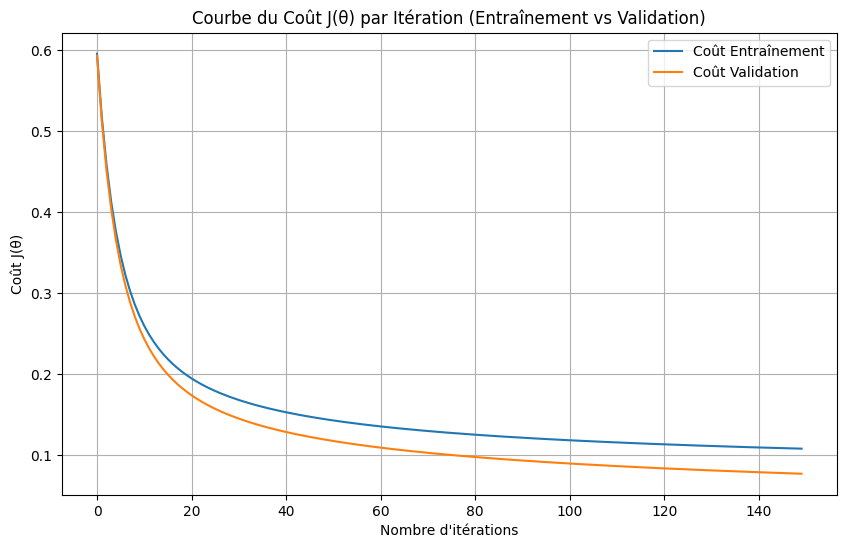

In [ ]:
import matplotlib.pyplot as plt

# Tracer la courbe de coût
plt.figure(figsize=(10, 6))
plt.plot(cost_history_train_opt, label='Coût Entraînement')
plt.plot(cost_history_val_opt, label='Coût Validation')
plt.xlabel("Nombre d'itérations")
plt.ylabel("Coût J(θ)")
plt.title("Courbe du Coût J(θ) par Itération (Entraînement vs Validation)")
plt.legend()
plt.grid(True)
plt.show()

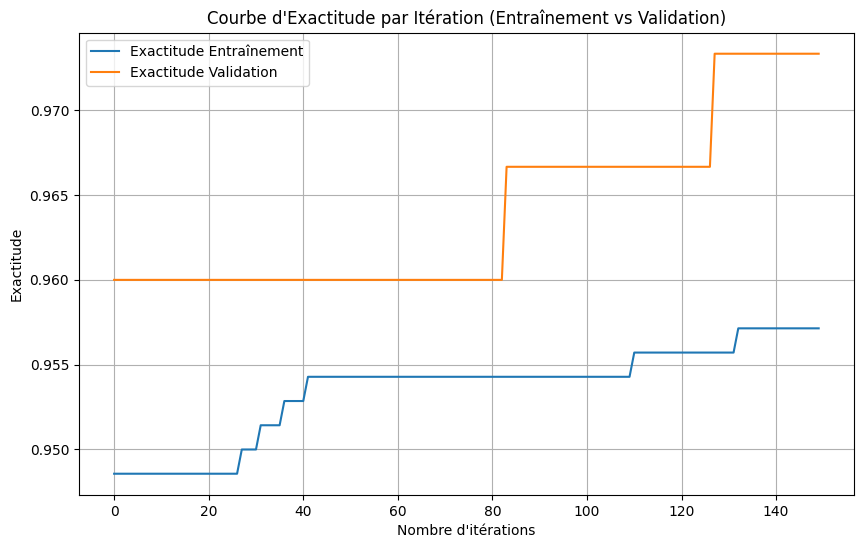

In [ ]:
import matplotlib.pyplot as plt

# Tracer la courbe d'exactitude
plt.figure(figsize=(10, 6))
plt.plot(accuracy_history_train_opt, label="Exactitude Entraînement")
plt.plot(accuracy_history_val_opt, label="Exactitude Validation")
plt.xlabel("Nombre d'itérations")
plt.ylabel("Exactitude")
plt.title("Courbe d'Exactitude par Itération (Entraînement vs Validation)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Afficher les paramètres optimaux theta
print("Paramètres optimaux θ :", theta_opt)

Paramètres optimaux θ : [ 3.74325121  0.81987518  0.17856822  0.94684791  0.59711098  0.54532063
  0.03051796 -0.93612345]


In [ ]:
# Calculer les métriques de performance (Accuracy, Precision, Recall (Rappel), F1-score) à l’aide de Scikit-learn.
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluation_metrics(X, y):
  predictions = prediction(X, theta_opt)
  accuracy = accuracy_score(y, predictions)
  precision = precision_score(y, predictions)
  recall = recall_score(y, predictions)
  f1 = f1_score(y, predictions)

  return accuracy, precision, recall, f1

# Évaluation sur chaque ensemble
perftrain = evaluation_metrics(X_train, y_train)
perfval = evaluation_metrics(X_val, y_val)
perftest = evaluation_metrics(X_test, y_test)

# creation d'un tableau comparatif des métriques pour train, val et test.
tableau = pd.DataFrame({
    'Ensemble': ['Train', 'Val', 'Test'],
    'Accuracy': [perftrain[0], perfval[0], perftest[0]],
    'Precision': [perftrain[1], perfval[1], perftest[1]],
    'Recall': [perftrain[2], perfval[2], perftest[2]],
    'F1-score': [perftrain[3], perfval[3], perftest[3]]
})

print("Tableau comparatif des performances :")
print(tableau)

Tableau comparatif des performances :
  Ensemble  Accuracy  Precision  Recall  F1-score
0    Train  0.957143   0.956772     1.0  0.977909
1      Val  0.973333   0.972973     1.0  0.986301
2     Test  0.926667   0.925170     1.0  0.961131


## 5. Analyse et Interprétation

1. Effet de la régularisation Ridge (λ) :
En regardant les matrices d'exactitude pour l'entraînement et la validation, on peut observer comment l'exactitude change lorsque lambda augmente (en se déplaçant horizontalement dans les matrices).
En efet, Sur les ensembles d'entraînement et de validation, une augmentation de lambda a tendance à diminuer légèrement l'exactitude.
Cela suggère que pour ce problème et cet ensemble de données, une faible régularisation Ridge est bénéfique (elle aide à la généralisation en empêchant les coefficients de devenir trop grands), mais une régularisation trop forte nuit à la performance en sur-simplifiant le modèle. Le meilleur lambda trouvé (0.1) semble être un bon équilibre.

2. Influence du taux d'apprentissage (α) sur la convergence :
En regardant les matrices d'exactitude (verticalement pour différentes valeurs d'alpha) et aussi les courbes de coût et d'exactitude, on peut voir l'effet du taux d'apprentissage.
Des taux d'apprentissage plus élevés (comme 0.51, le best_alpha) permettent généralement une convergence plus rapide (le coût diminue et l'exactitude augmente rapidement au début des itérations). On le voit sur les courbes : le coût chute et l'exactitude monte un peu vite.
Des taux d'apprentissage plus faibles (comme 0.01) entraînent une convergence plus lente ).

3. Signes de surapprentissage ou de sous-apprentissage :
** Surapprentissage (Overfitting) : On observe un surapprentissage si la performance sur l'ensemble d'entraînement est significativement meilleure que sur l'ensemble de validation. En regardant les courbes d'exactitude, l'exactitude d'entraînement est inferieure à celle de validation, mais l'écart ne semble pas énorme et les deux courbes suivent des tendances similaires. Le tableau comparatif montre aussi une exactitude d'entraînement un peu plus élevée (0.9571) que sur le test (0.9267), mais la validation (0.9733) est même meilleure que l'entraînement, ce qui suggère que le surapprentissage n'est pas prononcé avec les meilleurs hyperparamètres pour ce modele.
** Sous-apprentissage (Underfitting) : On observe un sous-apprentissage si la performance est faible à la fois sur l'ensemble d'entraînement et de validation. Ici, les exactitudes (autour de 95-97%) sont relativement élevées, ce qui suggère que le modèle n'est pas en sous-apprentissage sévère ; il semble avoir bien appris le schéma des données.

4. Cohérence des résultats (Train, Val, Test) :
Le tableau comparatif montre des métriques généralement bonnes sur les trois ensembles.
L'exactitude est la plus élevée sur l'ensemble de validation (0.9733), suivie de près par l'entraînement (0.9571), et un peu plus faible sur le test (0.9267). L'exactitude sur le test est un indicateur réaliste de la performance sur de nouvelles données complètement invisibles. je pense qu'une légère baisse sur le test par rapport à la validation n'est pas tres alarmant.
La Précision et le Score F1 suivent une tendance similaire.
Le Rappel est de 1.0 sur les trois ensembles. Un rappel de 1.0 signifie que le modèle a correctement identifié tous les cas positifs (classe 1) dans chaque ensemble. C'est une excellente performance en termes de détection des vrais positifs, mais il faut aussi regarder la précision : une précision légèrement inférieure à 1.0 (comme 0.9568 sur train, 0.9730 sur val, 0.9252 sur test) indique que, bien qu'il trouve tous les positifs mais le modèle fait aussi quelques fausses alarmes (prédit 1 alors que c'est 0).
Dans l'ensemble, les résultats sont assez cohérents. Le modèle semble bien généraliser, surtout considérant le rappel parfait sur les trois ensembles.

## RESUME:
En conclusion, le modèle de régression logistique avec régularisation Ridge, entraîné avec les meilleurs hyperparamètres trouvés (alpha=0.51, lambda=0.10), montre une bonne performance générale. La régularisation Ridge semble bénéfique à faible dose, et le taux d'apprentissage optimal permet une convergence rapide. Le modèle ne semble pas présenter de signes majeurs de sur-apprentissage ou de sous-apprentissage, et les résultats sur les ensembles d'entraînement, validation et test sont raisonnablement cohérents, avec une excellente capacité à identifier tous les cas positifs (rappel de 1.0).